# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
import plotnine as pln
from plotnine import ggplot, aes

# Load data

In [2]:
fetal_ad0 = sc.read("../data/h5ad/fetal_skin.norm.maternal_removed.20210611.h5ad")

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


In [3]:
fetal_ad0

AnnData object with n_obs × n_vars = 186582 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [6]:
fetal_ad0.obs.independent_annotation_refined.cat.categories

Index(['ASDC', 'Activated mac', 'Adipocytes', 'Arterial', 'B cell', 'Basal KC',
       'CD4 T cell', 'CD8 T cell', 'Capillary (venular tip)',
       'Capillary/postcapillary venule', 'DC1', 'DC2', 'Dermal condensate',
       'Dermal papillia', 'Early KC (stem cell)', 'Early LE',
       'Early endothelial cell', 'Early erythroid',
       'Early erythroid (embryonic)', 'Early fibroblast FRZB+',
       'Early fibroblast HOXC5+', 'Early myocytes',
       'Eo/baso/mast cell progenitor', 'Erythroid (embryonic)',
       'Erythroid (fetal)', 'Fibroblast WNT2+', 'Fibroblasts unknown', 'HSC',
       'Hair follicle', 'ILC2', 'ILC3', 'Inflammatory DC', 'LC', 'LE',
       'LTi cell', 'Lymphoid progenitor', 'MEMP - Early erythroid',
       'MEMP - Megak', 'Mac-mono', 'Macrophage1', 'Macrophage2',
       'Mast cell (earliest)', 'Mast cell (medium)', 'Mast cell (most mature)',
       'Megakaryocyte', 'Melanoblast', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte (activated/differentiating)', '

In [15]:
fetal_ad0.obs.independent_annotation_broad3.cat.categories

Index(['Adipocyte', 'B cell', 'CD4 T cell', 'CD8 T cell', 'DC',
       'Dermal condensate', 'Erythroid', 'Fibroblast',
       'Granulocyte progenitor', 'HSC', 'ILC', 'KC', 'Langerhans cell',
       'Lymphatic endothelium', 'MEMP', 'Macrophage', 'Mast cell',
       'Megakaryocyte', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte precursor', 'Muscle', 'Myofibroblast', 'NK T cell', 'NK cell',
       'Neuronal cells', 'Neutrophil', 'Pericyte', 'Treg',
       'Vascular endothelium'],
      dtype='object')

In [16]:
fibro = fetal_ad0[fetal_ad0.obs.independent_annotation_broad3 == "Fibroblast"]

In [7]:
wnt2_fibro = fetal_ad0[fetal_ad0.obs.independent_annotation_refined == "Fibroblast WNT2+"]

In [20]:
pear1_fibro = fetal_ad0[fetal_ad0.obs.independent_annotation_refined == "Fibroblasts unknown"]

In [8]:
wnt2_fibro

View of AnnData object with n_obs × n_vars = 29109 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [24]:
pear1_fibro

AnnData object with n_obs × n_vars = 3787 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'fibrotic_up', 'pcw2'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    uns: 'pcw2_colors'
    obsm: 'X_umap1', 'X_umap2'

In [17]:
sc.tl.score_genes(
    fibro,
    ["POSTN", "COMP", "COL11A1", "COL12A1", "COL5A2", "SDC1", "ADAM12", "CD266"],
    score_name="fibrotic_up",
)

Trying to set attribute `.obs` of view, copying.


In [9]:
sc.tl.score_genes(
    wnt2_fibro,
    ["POSTN", "COMP", "COL11A1", "COL12A1", "COL5A2", "SDC1", "ADAM12", "CD266"],
    score_name="fibrotic_up",
)

Trying to set attribute `.obs` of view, copying.


In [21]:
sc.tl.score_genes(
    pear1_fibro,
    ["POSTN", "COMP", "COL11A1", "COL12A1", "COL5A2", "SDC1", "ADAM12", "CD266"],
    score_name="fibrotic_up",
)

Trying to set attribute `.obs` of view, copying.


In [18]:
fibro.obs["pcw2"] = fibro.obs["pcw"].astype("category")

In [11]:
wnt2_fibro.obs["pcw2"] = wnt2_fibro.obs["pcw"].astype("category")

In [29]:
pear1_fibro.obs["pcw2"] = pear1_fibro.obs["pcw"].astype("category")

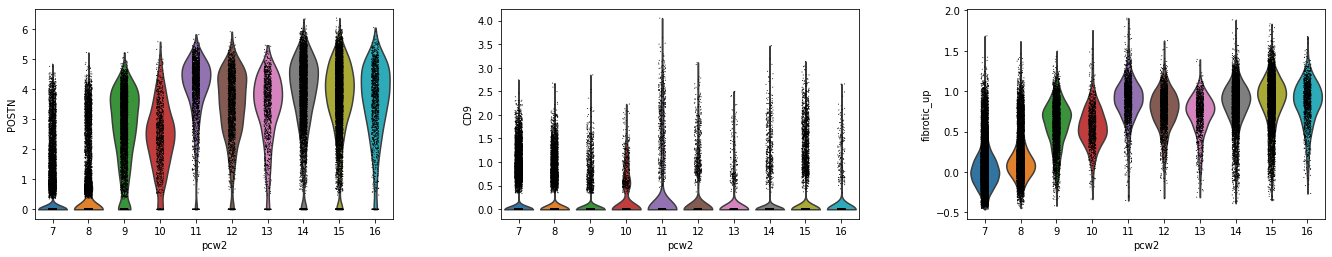

In [34]:
sc.pl.violin(fibro, ["POSTN", "CD9", "fibrotic_up"], groupby="pcw2")

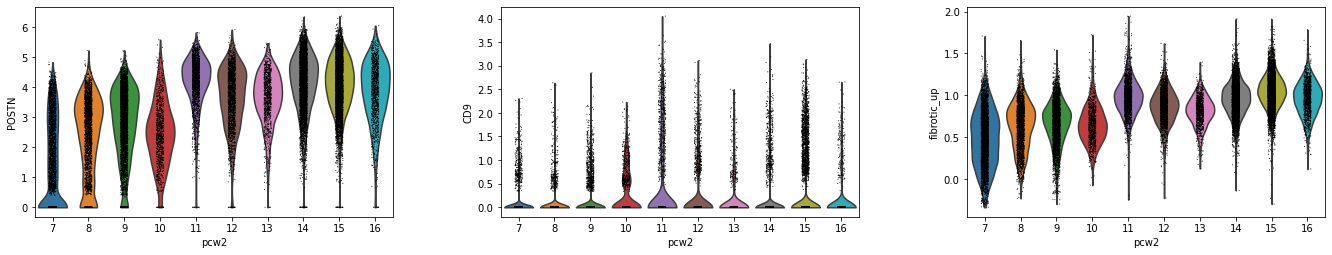

In [35]:
sc.pl.violin(wnt2_fibro, ["POSTN", "CD9", "fibrotic_up"], groupby="pcw2")

make heatmap

In [46]:
DE_genes = pd.read_csv(
    "../20210611_final_object/deg/fetal_skin.Mesenchymalcells.wilcoxon.deg_top100.tsv", sep="\t"
)

In [201]:
top3_DE_genes = DE_genes.loc[DE_genes.cluster.isin(fibro.obs.independent_annotation_refined.cat.categories)].groupby("cluster").head(5).genes.to_list()

In [202]:
fibrotic_genes = ["POSTN", "COMP", "COL11A1", "COL12A1", "COL5A2", "SDC1", "ADAM12"]

In [203]:
fibro

AnnData object with n_obs × n_vars = 59048 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'fibrotic_up', 'pcw2', 'Unit'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    uns: 'pcw2_colors'
    obsm: 'X_umap1', 'X_umap2'

In [204]:
fibro.obs["Unit"] = (
    fibro.obs.independent_annotation_refined.astype(str) + ";" + fibro.obs.pcw.astype(str)
).astype("category")

In [205]:
fibro.obs.Unit.value_counts()

Early fibroblast FRZB+;7      10783
Early fibroblast HOXC5+;7      8084
Early fibroblast HOXC5+;8      6993
Fibroblast WNT2+;15            6810
Fibroblast WNT2+;14            5426
Fibroblast WNT2+;9             4031
Fibroblast WNT2+;7             3454
Fibroblast WNT2+;8             2613
Fibroblasts unknown;15         1914
Fibroblast WNT2+;11            1866
Fibroblast WNT2+;12            1811
Fibroblast WNT2+;16            1133
Fibroblast WNT2+;13            1018
Fibroblast WNT2+;10             947
Fibroblasts unknown;14          811
Fibroblasts unknown;12          301
Early fibroblast HOXC5+;9       192
Fibroblasts unknown;16          170
Fibroblasts unknown;11          167
Fibroblasts unknown;13          138
Fibroblasts unknown;9           109
Fibroblasts unknown;10           98
Fibroblasts unknown;8            43
Fibroblasts unknown;7            36
Early fibroblast FRZB+;15        22
Early fibroblast FRZB+;9         18
Early fibroblast FRZB+;8         18
Early fibroblast FRZB+;14   

In [206]:
X = fibro[:, top3_DE_genes + fibrotic_genes].X.toarray()

In [207]:
X.shape

(59048, 27)

In [208]:
X = sklearn.preprocessing.scale(np.concatenate((X, fibro.obs.fibrotic_up.values.reshape(59048, 1)), axis=1))

In [209]:
data_df = pd.DataFrame(
    npg.aggregate(fibro.obs.Unit.cat.codes, sklearn.preprocessing.scale(X), func="mean", axis=0),
    index=fibro.obs.Unit.cat.categories,
    columns=top3_DE_genes + fibrotic_genes + ["fibrotic_up_score"],
)

In [210]:
data_df

,RPS4Y1,FRZB,SLC6A13,RBP1,CYP1B1,QPRT,F13A1,RP11-834C11.4,FABP7,APCDD1,...,AHR,BNC2,POSTN,COMP,COL11A1,COL12A1,COL5A2,SDC1,ADAM12,fibrotic_up_score
Early fibroblast FRZB+;10,-0.530656,0.076709,-0.398913,-0.104786,1.226115,-0.554588,-0.485167,-0.064416,-0.527903,-0.619949,...,1.775718,1.541313,-0.603802,-0.073328,1.401839,-0.879280,-0.702870,-0.143135,-0.393445,-0.711863
Early fibroblast FRZB+;11,-0.530656,-0.175578,-0.398913,-0.894867,-0.396591,-0.679862,-0.485167,-0.677042,-0.285141,-0.535570,...,0.678369,0.480227,0.438134,2.436880,2.155870,0.472265,0.081045,-0.037211,0.471622,0.874938
Early fibroblast FRZB+;12,1.723930,0.432061,-0.398913,-0.897407,0.980539,-0.362397,-0.485167,-0.393956,-0.527903,-0.608475,...,2.535837,0.858570,-0.486732,-0.073328,1.154850,-0.226655,0.217092,0.221474,0.783603,-0.039054
Early fibroblast FRZB+;14,-0.530656,0.760177,-0.398913,-0.916768,-0.328581,-0.883271,-0.485167,0.170942,-0.411895,-0.302266,...,1.299281,-0.180162,-0.077097,-0.073328,-0.418244,-0.296049,-0.070939,-0.304685,0.038204,-0.289518
Early fibroblast FRZB+;15,-0.530656,0.555331,-0.398912,-0.703461,0.434027,-0.824323,-0.485167,-0.673719,-0.527903,-0.607495,...,1.784062,0.198754,-0.501520,-0.073328,0.717178,-0.392639,-0.177765,-0.167553,-0.049743,-0.470535
Early fibroblast FRZB+;16,-0.530656,-0.479006,-0.398913,-0.810694,-0.481529,-0.481274,0.042583,-0.925771,-0.527903,-0.795459,...,0.517942,-0.505268,-0.335711,-0.073328,-0.418244,-0.192085,0.271883,0.395311,2.578938,0.116224
Early fibroblast FRZB+;7,1.749097,1.822878,1.780580,1.541940,1.762040,-0.298879,-0.476666,-0.903196,-0.495381,-0.204231,...,-0.259028,-0.010433,-0.859311,-0.066023,0.429381,-1.216022,-0.774855,0.355766,0.183348,-1.004572
Early fibroblast FRZB+;8,0.101367,0.462964,-0.398912,-0.018775,-0.454149,0.338063,-0.401601,-0.295140,0.037255,-0.120607,...,-0.207191,0.425335,0.221955,-0.073328,1.092329,-0.432880,0.264212,0.206653,-0.314626,0.176903
Early fibroblast FRZB+;9,-0.378416,1.717639,1.192919,0.759213,1.294079,-0.003251,-0.446624,-0.652094,-0.449006,-0.429617,...,-0.336854,1.090791,-0.900403,-0.073328,1.951270,-0.673105,-0.544071,0.353292,1.262169,-0.497374
Early fibroblast HOXC5+;10,-0.530656,-0.479006,-0.398913,-1.106507,-0.481529,-0.883271,1.029246,0.807628,1.366919,1.339623,...,-0.336854,-0.505268,-0.999996,-0.073328,-0.418244,-0.776331,-1.012512,-0.442182,1.519594,-0.929230


In [211]:
data_df[["celltype", "pcw"]] = pd.Series(data_df.index, index=data_df.index).str.split(
    ";", expand=True
)

In [212]:
data_df["pcw"] = data_df["pcw"].astype('category')
data_df["pcw"].cat.reorder_categories(["7", "8", "9", "10", "11", "12", "13", "14", "15", "16"], inplace=True)

In [213]:
plot_df = data_df.melt(
    id_vars=["celltype", "pcw"],
    value_vars=top3_DE_genes + fibrotic_genes + ["fibrotic_up_score"],
    var_name="gene",
    value_name="expression",
)

In [214]:
plot_df["gene"] = plot_df["gene"].astype("category")
plot_df["gene"].cat.reorder_categories(top3_DE_genes + fibrotic_genes + ["fibrotic_up_score"], inplace=True)

In [215]:
plot_df.head()

,celltype,pcw,gene,expression
0,Early fibroblast FRZB+,10,RPS4Y1,-0.530656
1,Early fibroblast FRZB+,11,RPS4Y1,-0.530656
2,Early fibroblast FRZB+,12,RPS4Y1,1.723930
3,Early fibroblast FRZB+,14,RPS4Y1,-0.530656
4,Early fibroblast FRZB+,15,RPS4Y1,-0.530656


In [216]:
plot_df.celltype.value_counts()

Fibroblasts unknown        280
Fibroblast WNT2+           280
Early fibroblast FRZB+     252
Early fibroblast HOXC5+    140
Name: celltype, dtype: int64

In [217]:
fibrotic_genes

['POSTN', 'COMP', 'COL11A1', 'COL12A1', 'COL5A2', 'SDC1', 'ADAM12']

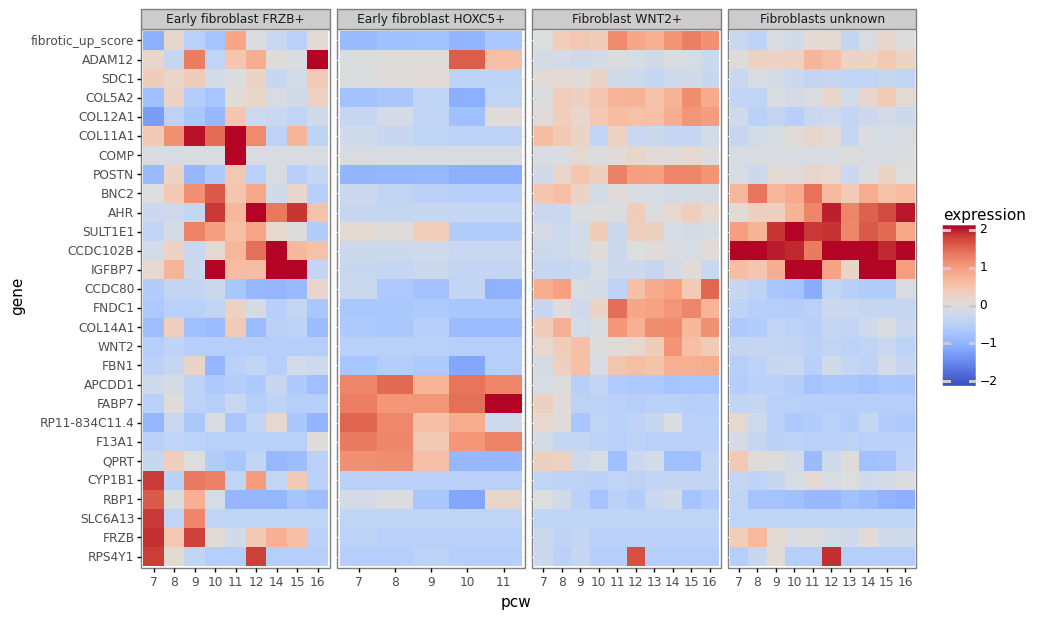

<ggplot: (8786601406446)>

In [218]:
pln.options.figure_size = (10, 7)
(
    pln.ggplot(plot_df, pln.aes(x="pcw", y="gene"))
    + pln.facet_grid(".~celltype", scales="free_x", space="free_x")
    + pln.geom_tile(pln.aes(fill="expression"))
    + pln.scale_fill_cmap("coolwarm", limits=(-2, 2))
    + pln.theme_bw()
    + pln.theme()
)